# Computer Vision : GANs

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/dcgan

## Importing the libraries

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.18.0'

## Loading and pre-processing the dataset

In [115]:
# x축은 항상 대문자로
# X_train, y_train : 각각 훈련 이미지와 레이블 저장
# (_, _) : 테스트 데이터셋 

(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [116]:
X_train.shape

(60000, 28, 28)

In [117]:
y_train.shape

(60000,)

In [118]:
np.random.randint(0, 60000)

10865

4


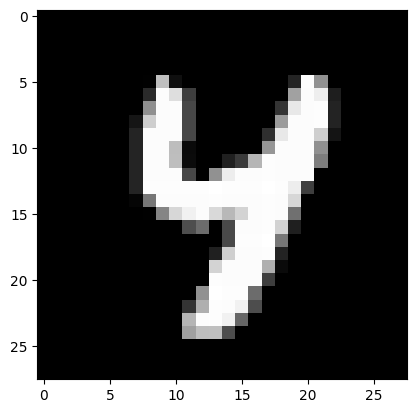

In [119]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [120]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [121]:
X_train.shape

(60000, 28, 28, 1)

In [122]:
X_train = X_train / 255

In [123]:
X_training = (X_train - 127.5) / 127.5

In [124]:
X_train[0].min(), X_train[0].max()

(0.0, 1.0)

In [125]:
buffer_size = 60000
batch_size = 256

In [126]:
buffer_size / batch_size

234.375

In [127]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [128]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

## Building the generator(수업 후에 꼭 읽어 보세요.제발 플리즈)

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [93]:
def build_generator():
    network = tf.keras.Sequential()

    network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    network.add(layers.Reshape((7, 7, 256)))

    # 7x7x128
    network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    # 14x14x64
    network.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    # 28x28x1
    network.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', use_bias=False))
    
    network.summary()

    return network



In [ ]:
generator = build_generator()

/opt/anaconda3/envs/llm/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [95]:
noise = tf.random.normal([1, 100])

In [96]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-2.0635863e-01,  1.0175948e+00, -7.4221218e-01,  3.8380783e-02,
         1.0359180e+00, -2.8319004e-01, -7.3393708e-01,  2.1505227e+00,
        -1.0439223e+00,  7.7948636e-01, -8.9720798e-01,  3.3956373e-01,
        -4.8616043e-01,  1.2616065e+00, -7.9892717e-02, -4.1999015e-01,
         5.5297565e-01,  3.6947456e-01,  1.8045694e+00,  2.4489728e-01,
         5.5274975e-01,  6.2821108e-01, -2.8604746e-01,  3.2239136e-01,
        -2.3145869e+00,  1.6801313e+00, -2.3957194e-01,  5.5594981e-01,
        -1.3269827e+00, -5.4710901e-01, -3.4584171e-01, -5.2206850e-01,
         5.5220133e-01, -1.5696540e+00, -3.9973000e-01, -5.3851479e-01,
         3.9129153e-02, -4.0406603e-01,  5.4860002e-01,  7.9291797e-01,
         2.0670655e-01,  5.2904940e-01, -3.4303367e-01, -1.0024803e+00,
         1.7053846e+00, -7.2055012e-02, -1.7104660e-01, -5.8654869e-01,
         3.2754642e-01, -1.9183742e+00,  5.6126714e-01, -2.2642772e+00,
         1.046

In [97]:
generated_image = generator(noise, training = False)

In [98]:
generated_image.shape

TensorShape([1, 28, 28, 1])

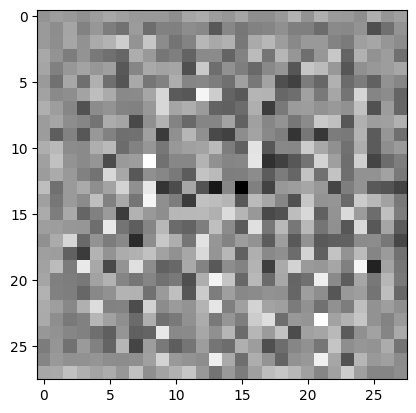

In [99]:
# plt.imshow(generated_image[0,:,:,:0], cmap='gray')
# dimension 에러로 코드 수정
plt.imshow(generated_image[0,:,:,:3], cmap='gray')

## Building the discriminator

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [100]:
def build_discriminator():
    network = tf.keras.Sequential()

    # 14x14x64
    network.add(layers.Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    # 7x7x128
    network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Flatten())
    network.add(layers.Dense(1))

    network.summary()

    return network

In [ ]:
discriminator = build_discriminator()

/opt/anaconda3/envs/llm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00106514]], dtype=float32)>

## Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [103]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [104]:
def discriminator_loss(expected_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [105]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [106]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Training the model

In [107]:
@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        expected_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [108]:
epochs = 100	# 학습횟수
noise_dim = 100	# noise dimension: 인풋값에 넣을 랜덤값 수
num_images_to_generate = 16	# 만들 이미지 수

In [109]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In [110]:
test_images.shape

TensorShape([16, 100])

In [111]:
def train(dataset, epochs, text_images):
    for epoch in range(epochs):
        for image_batch in dataset:
            #print(image_batch.shape)
            train_steps(image_batch)

        print('Epoch: ', epoch + 1)
        generated_images = generator(test_images, training = False)
        fig = plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.show()

In [112]:
epochs = 10

In [ ]:
train(X_train, epochs, test_images)

KeyboardInterrupt: 